Target C6H6(GT)

* EDA: exploration of variables and properties of data with conclusions -  1
* Data preparation:  all  missing values  are filled/dropped with explanation of why some methodwas chosen -  1
* Data preparation: normalization of data / scaling -  1
* Baseline model - linear regression without regularization - 1
* Feature engineering -  basic transformations (nonlinear) -  2
* Metrics chosen as well as reasoning behind each metric - 1
* Feature importance, hyperparameters tuning -  1
* Statistics material used (residual analysis, factor-importance hypothesis testing) - 1
* Non-classic regression (SVM-regression, Kernel-regression, SGD-regression)-  1

In [210]:
import pandas as pd
import seaborn as sns

В файле были пустые строки в конце и абсолютно пустые последние столбцы, удалил всё это вручную

In [211]:
df = pd.read_csv('./AirQualityUCI.csv', sep=';', decimal=",")
df.head()

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6         1360       150      11.9   
1  10/03/2004  19.00.00     2.0         1292       112       9.4   
2  10/03/2004  20.00.00     2.2         1402        88       9.0   
3  10/03/2004  21.00.00     2.2         1376        80       9.2   
4  10/03/2004  22.00.00     1.6         1272        51       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972   
2            939      131          1140      114          1555         1074   
3            948      172          1092      122          1584         1203   
4            836      131          1205      116          1490         1110   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7867  
4  11.2  59.6  0.7888

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
Date             9357 non-null object
Time             9357 non-null object
CO(GT)           9357 non-null float64
PT08.S1(CO)      9357 non-null int64
NMHC(GT)         9357 non-null int64
C6H6(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null int64
NOx(GT)          9357 non-null int64
PT08.S3(NOx)     9357 non-null int64
NO2(GT)          9357 non-null int64
PT08.S4(NO2)     9357 non-null int64
PT08.S5(O3)      9357 non-null int64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


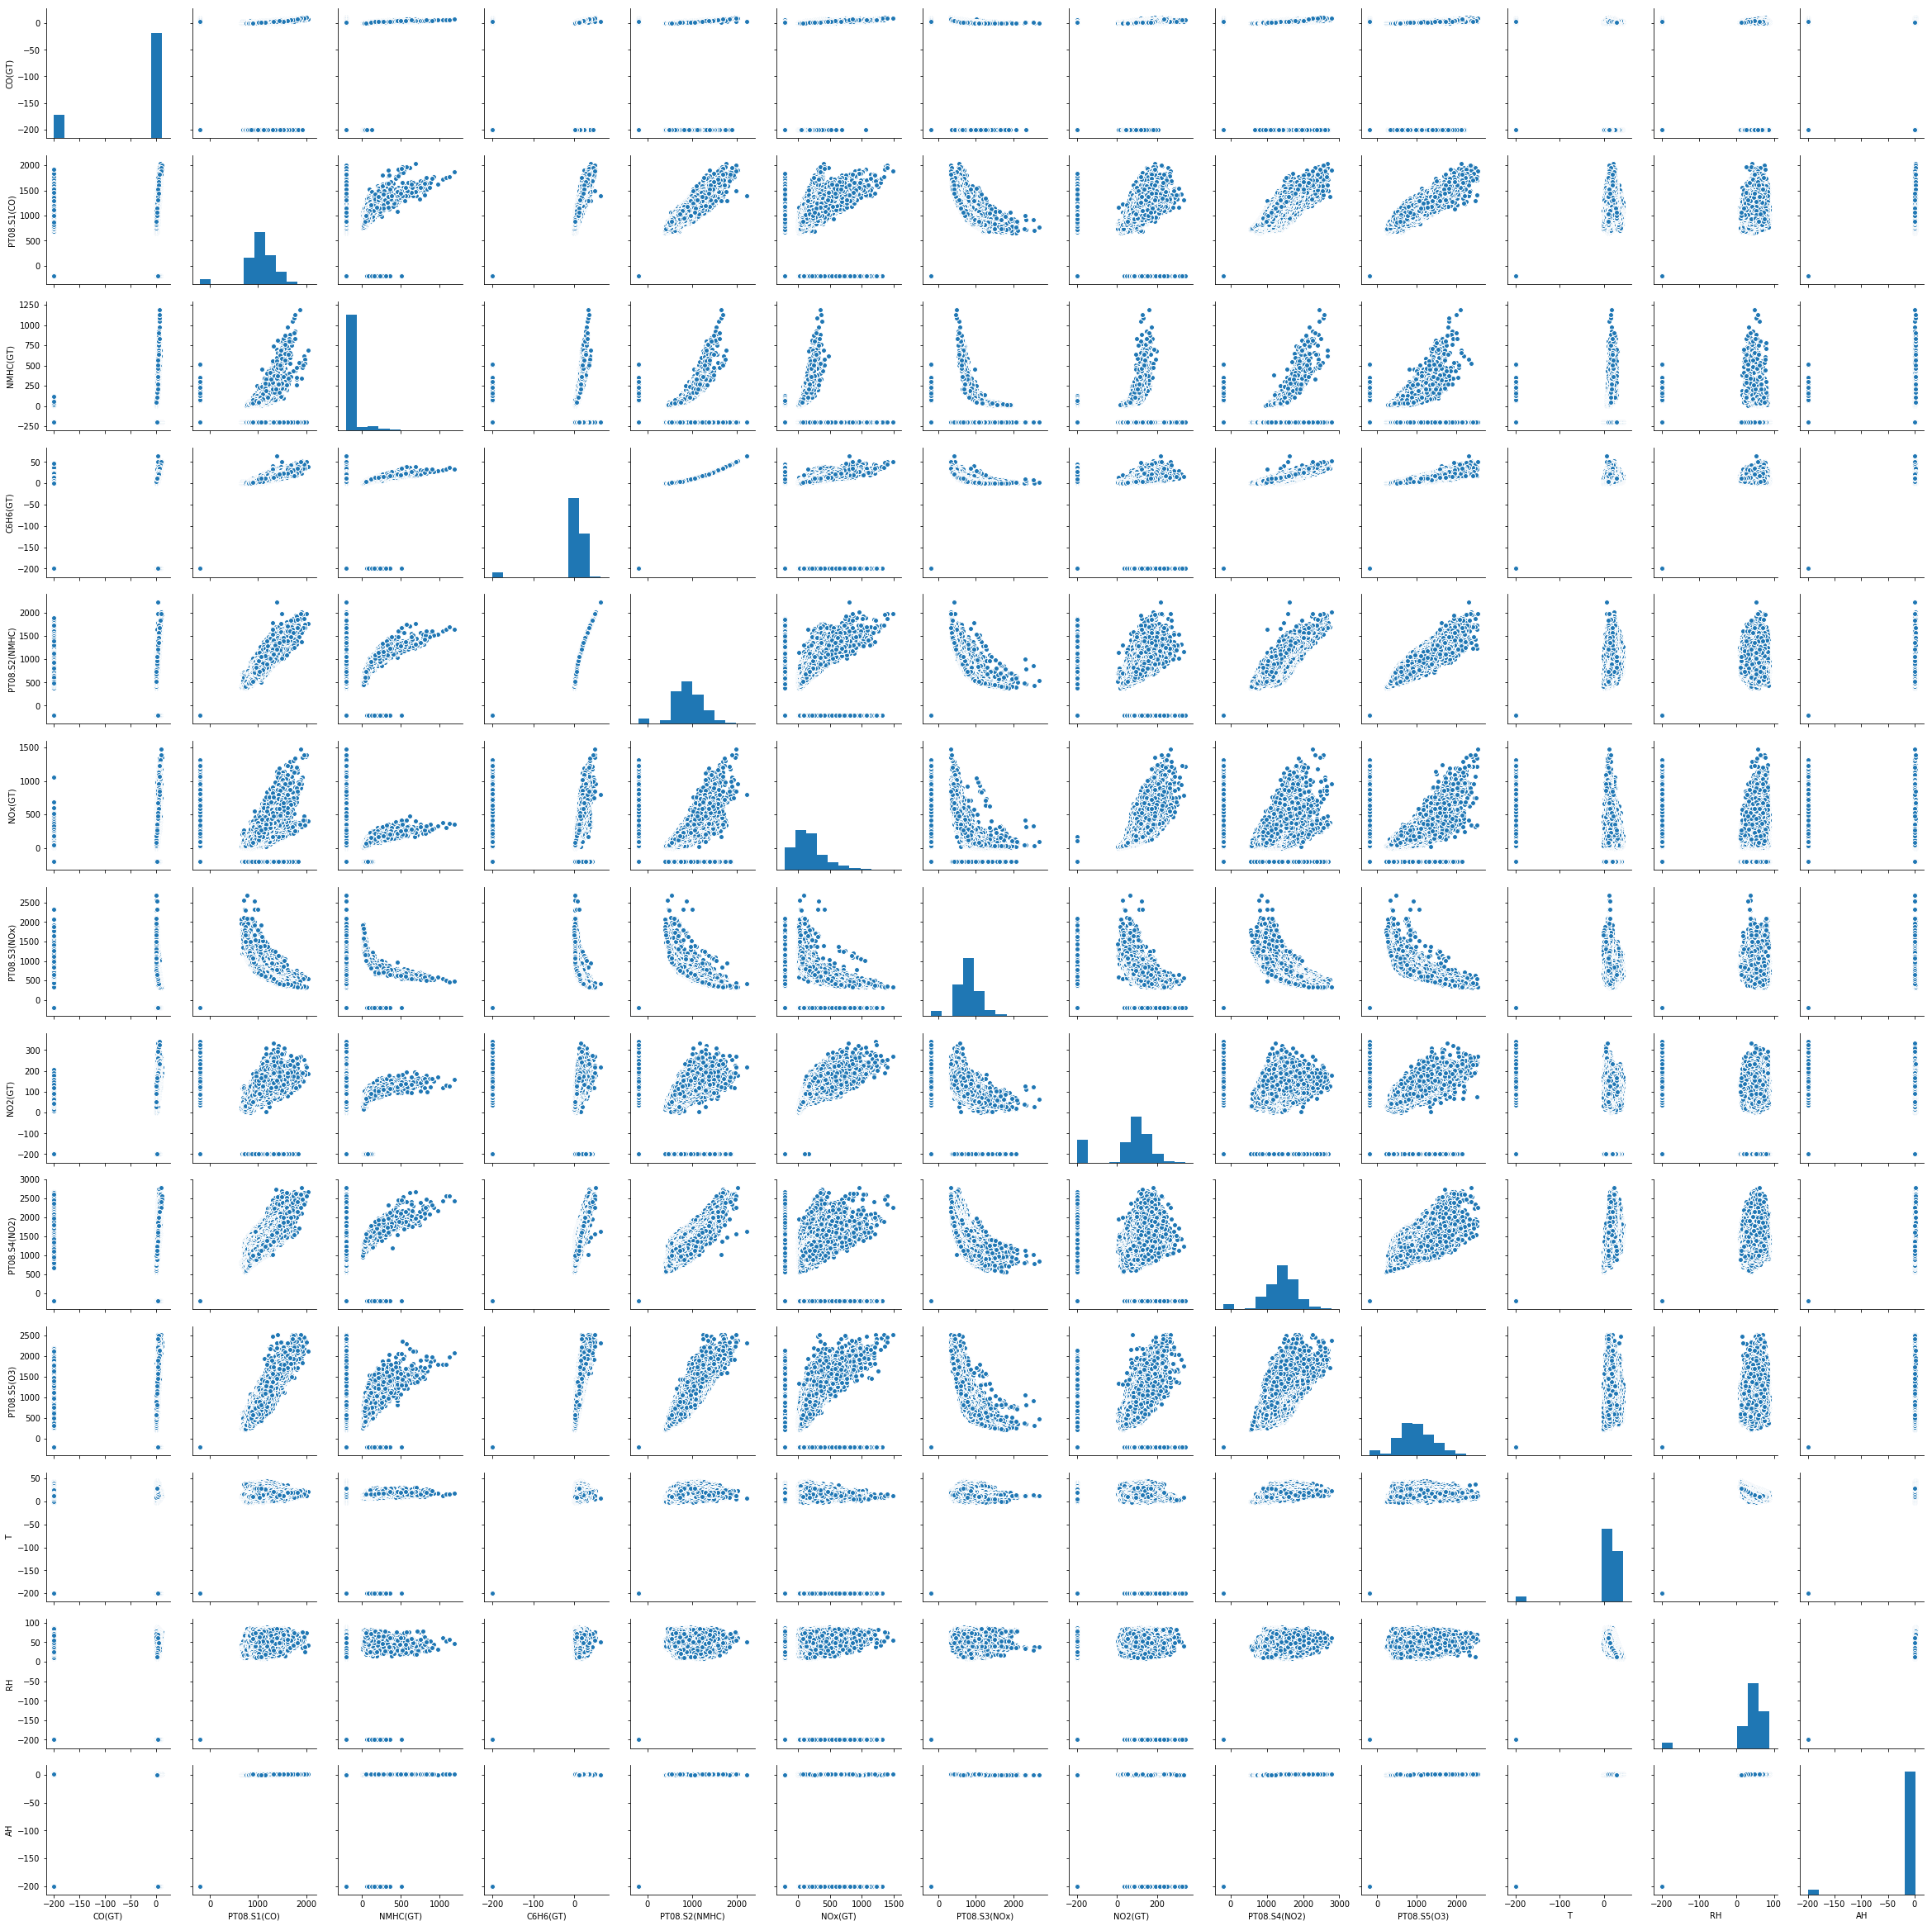

In [19]:
sns.pairplot(df)

Видно что есть пропущенные значения, впрочем это неудивительно, ибо написано в описании к датасету. На множестве признаков местами видны явно нелинейные зависимости. Но нас интересует таргет, а с ним другие признаки ведут себя 1) неясно, но это нормально (влажность, температура) 2) весьма линейно (PT08.S5(O3), PT08.S4(NO2), PT08.S3(NOx), NMHC(GT), PT08.S1(CO)), 3) чуть нелинйная (PT08.S3(NOx), PT08.S2(NMHC)). Напрягает совершенно разное распределение информации с датчиков и ground truth для, например, CO. Судя по гистограмме, NMHC(GT) имеет очень много пропусков.

In [22]:
df['NMHC(GT)'].value_counts()[-200], len(df)

(8443, 9357)

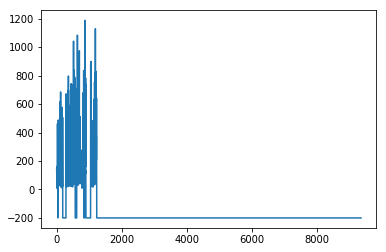

In [35]:
df['NMHC(GT)'].plot()

Ну да, можно сказать, что по этому признаку информации нет вовсе, поэтому конкретно тут ни о каком заполнении средним значением речи идти не может

In [28]:
df.corr()['C6H6(GT)']

CO(GT)          -0.031378
PT08.S1(CO)      0.852687
NMHC(GT)         0.037323
C6H6(GT)         1.000000
PT08.S2(NMHC)    0.767433
NOx(GT)         -0.001174
PT08.S3(NOx)     0.512193
NO2(GT)         -0.010992
PT08.S4(NO2)     0.774673
PT08.S5(O3)      0.641334
T                0.971375
RH               0.925062
AH               0.984555
Name: C6H6(GT), dtype: float64

Видно, что да, действительно есть корреляция неплохая между таргетом и несколькими фичами, однако дофига странно, что она такая супервысокая с тремя последними признаками, т.е. с температурой и влажностью. Объяснить это с идейной химической точки зрения я не могу, возможно наоборот, это следствия таких значений таргета, поэтому оставим это как есть, но будет аккуратными. Поскольку корреляция таки есть, то оправдано применение регрессионных моделей, хотя можно действовать и другими способами, например аримой, ведь у нас здесь временной ряд

Добавим нормальную колонку со временем чтобы дальше вытянуть отсюда какую-то информацию, удалим исходные

In [212]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S', exact=True)
df.drop(columns=['Date', 'Time'], inplace=True)
df.head()

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0     2.6         1360       150      11.9           1046      166   
1     2.0         1292       112       9.4            955      103   
2     2.2         1402        88       9.0            939      131   
3     2.2         1376        80       9.2            948      172   
4     1.6         1272        51       6.5            836      131   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  \
0          1056      113          1692         1268  13.6  48.9  0.7578   
1          1174       92          1559          972  13.3  47.7  0.7255   
2          1140      114          1555         1074  11.9  54.0  0.7502   
3          1092      122          1584         1203  11.0  60.0  0.7867   
4          1205      116          1490         1110  11.2  59.6  0.7888   

             DateTime  
0 2004-03-10 18:00:00  
1 2004-03-10 19:00:00  
2 2004-03-10 20:00:00  
3 2004-03-10 21:00:00  
4 2004-03-10 22:00:00

Некоторые признаки имеют довольно большой разброс, поэтому тупо вставить средние значения может не очень хорошо сказаться на качестве модели, надо скорее всего действовать умно, т.е. усреднять не по всему датасету, а, например по ближайшему месяцу от конкретного наблюдения (т.е. две недели вперед и две недели назад), либо по всем значениям в данное время дня и т.п.

Возможно, получится построить неплохую модель малыми силыми, поэтому попробуем просто выкинуть наблюдения с пропусками, и вместе с ними целый столбец NMHC(GT), ибо больно он уж бесполезный (на первыйи и неприхотливый взгляд)

Но для начала выкинем наблюдения с пропусками  (на трейне модель будет хуже, на тесте качество тоже будет хуже)

In [485]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import numpy as np

In [214]:
df1 = df.drop(columns=['NMHC(GT)']).replace({-200: np.nan}).dropna(how='any')

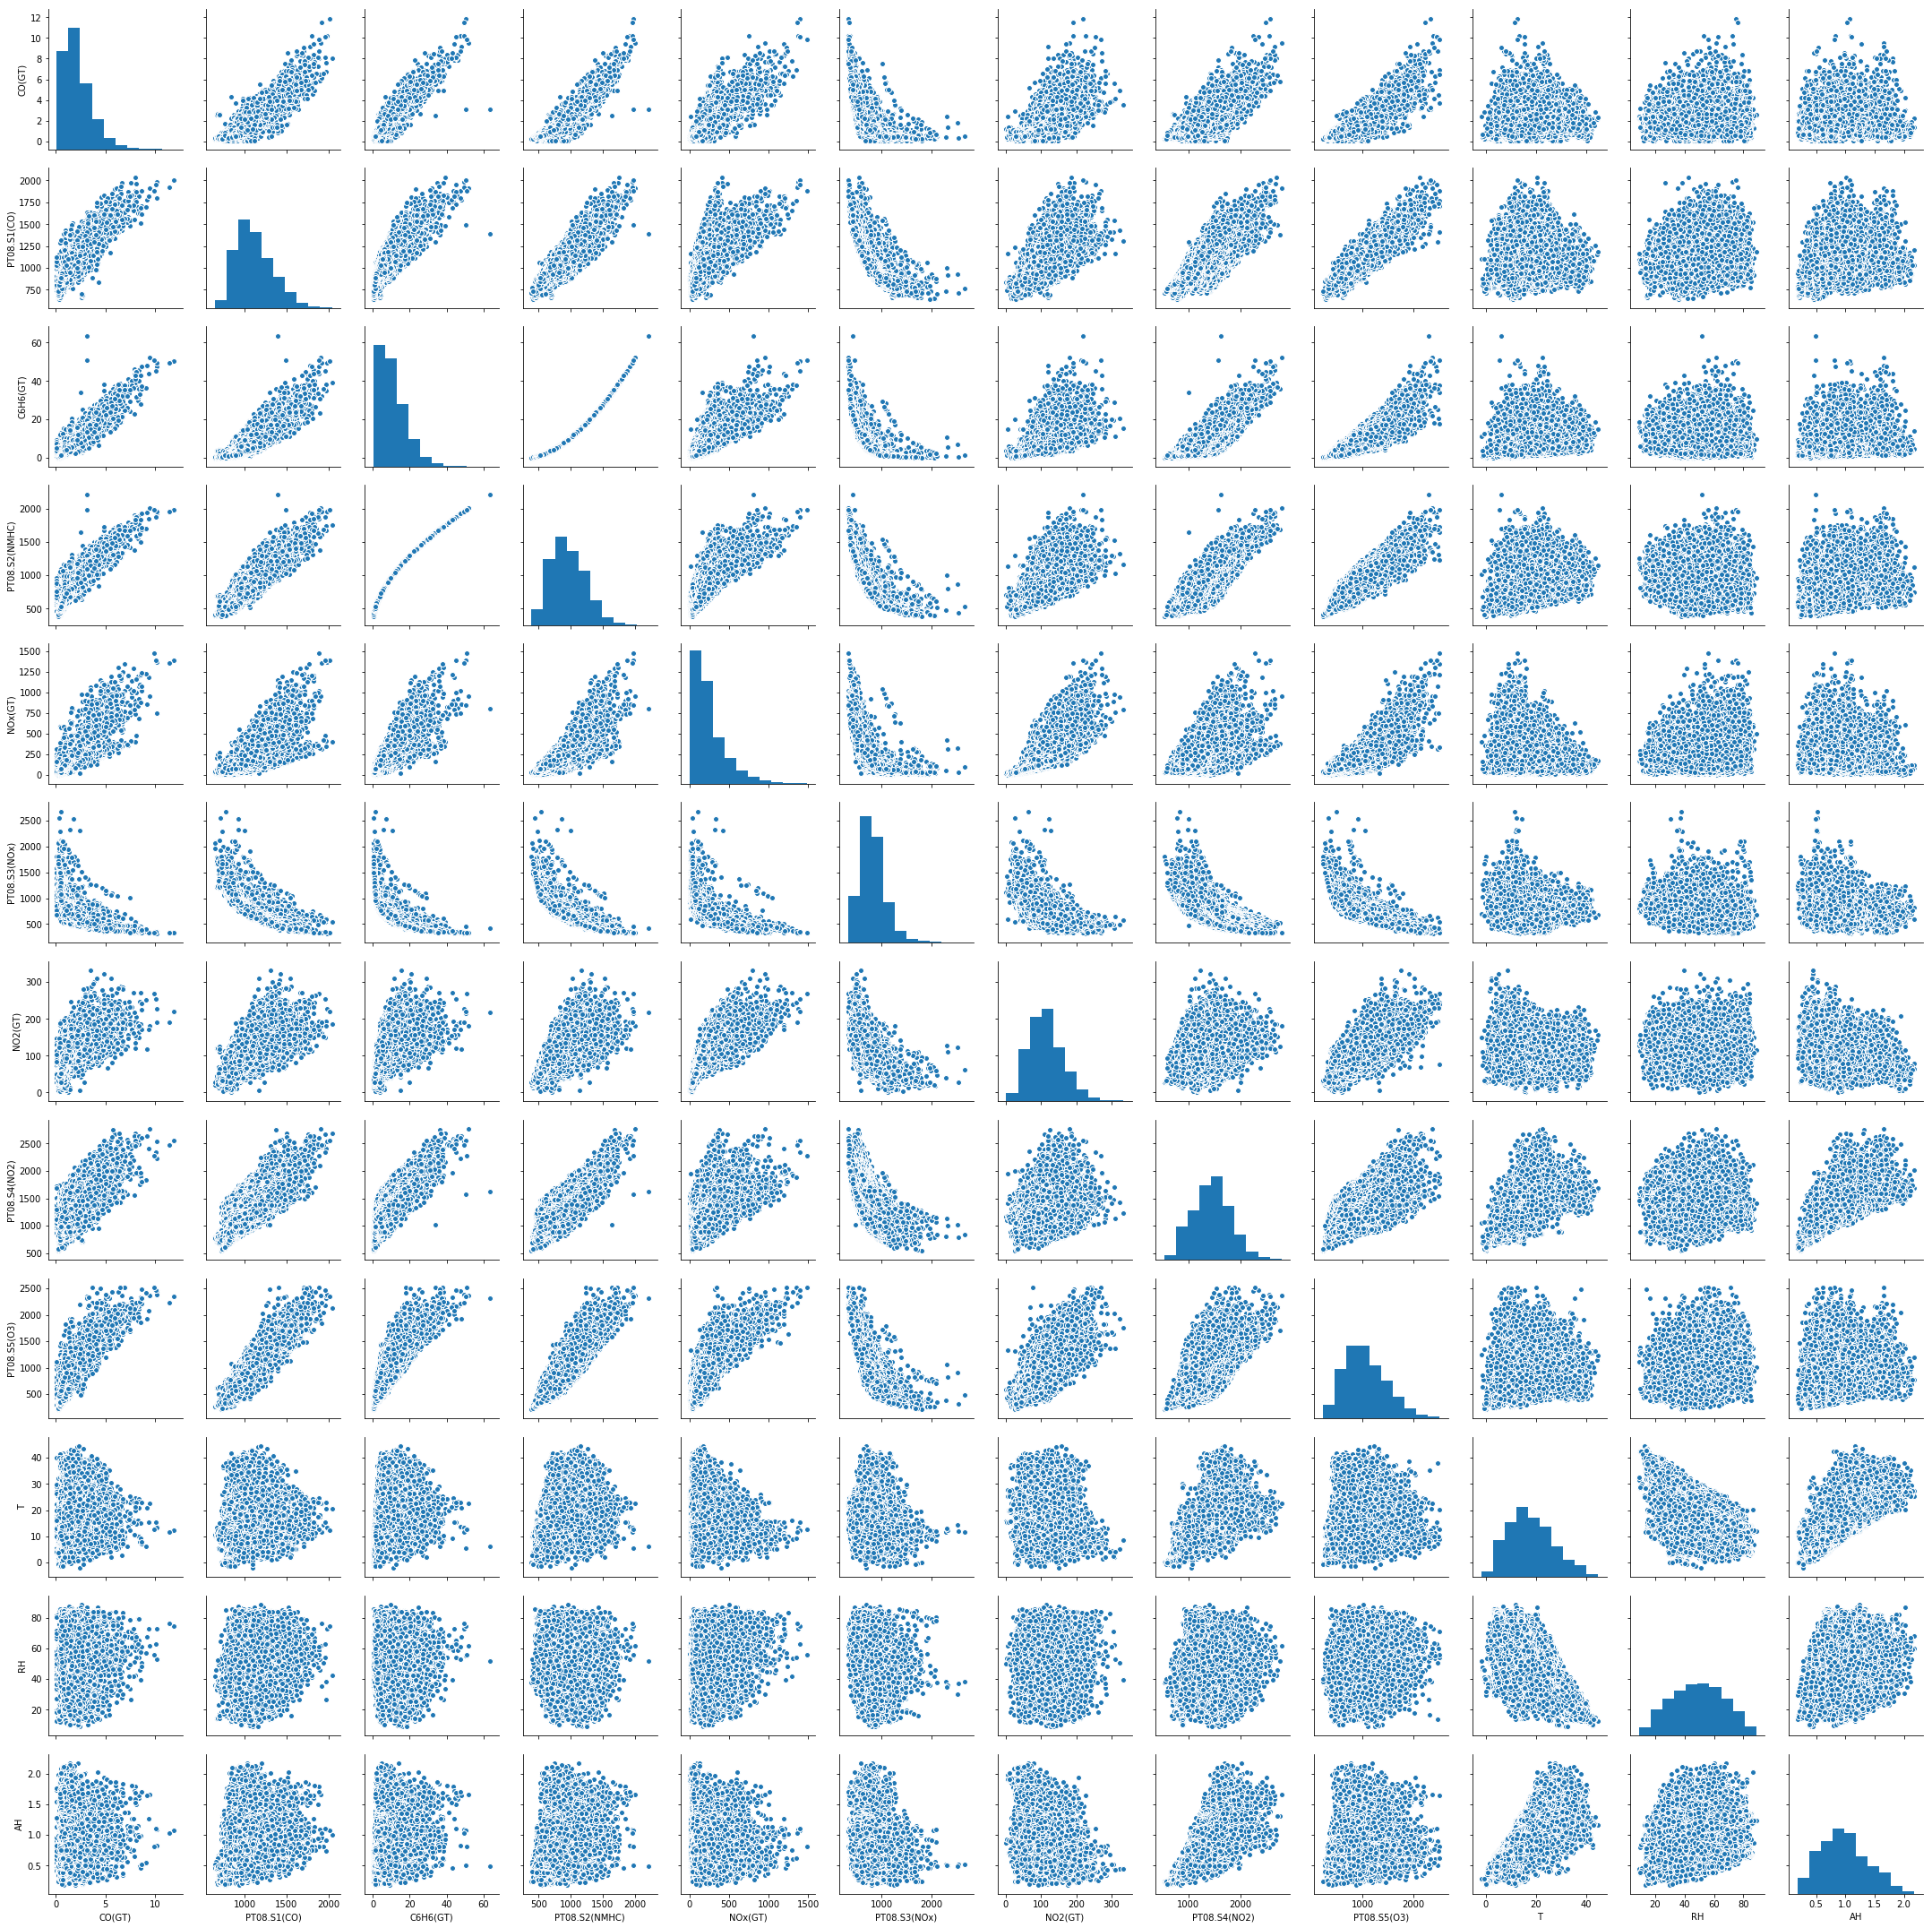

In [215]:
sns.pairplot(df1)

Ололо, картина уже не такая радужная, не такие уж там прямо линейные зависимости, где казалось они были, да и вообще предположения можно сказать в целом оказались неверными. Кроме того, есть выбросы в виде отдельных точек, отстоящих относительно вдалеке от основного облака. Удалим ручками выбросы, снова построим график

In [216]:
df1 = df1.drop(df1[df1['C6H6(GT)'] > 60].index)
df1 = df1.drop(df1[(df1['CO(GT)'] < 4) & (df1['C6H6(GT)'] > 30)].index)
df1 = df1.drop(df1[(df1['PT08.S1(CO)'] < 1600) & (df1['C6H6(GT)'] > 45)].index)
df1 = df1.drop(df1[df1['PT08.S3(NOx)'] > 2200].index)
df1 = df1.drop(df1[(df1['PT08.S4(NO2)'] < 1700) & (df1['C6H6(GT)'] > 32)].index)
df1 = df1.drop(df1[df1['CO(GT)'] > 11].index)
df1 = df1.drop(df1[(df1['NOx(GT)'] > 1300) & (df1['C6H6(GT)'] > 40)].index)
df1 = df1.drop(df1[df1['C6H6(GT)'] > 50].index)

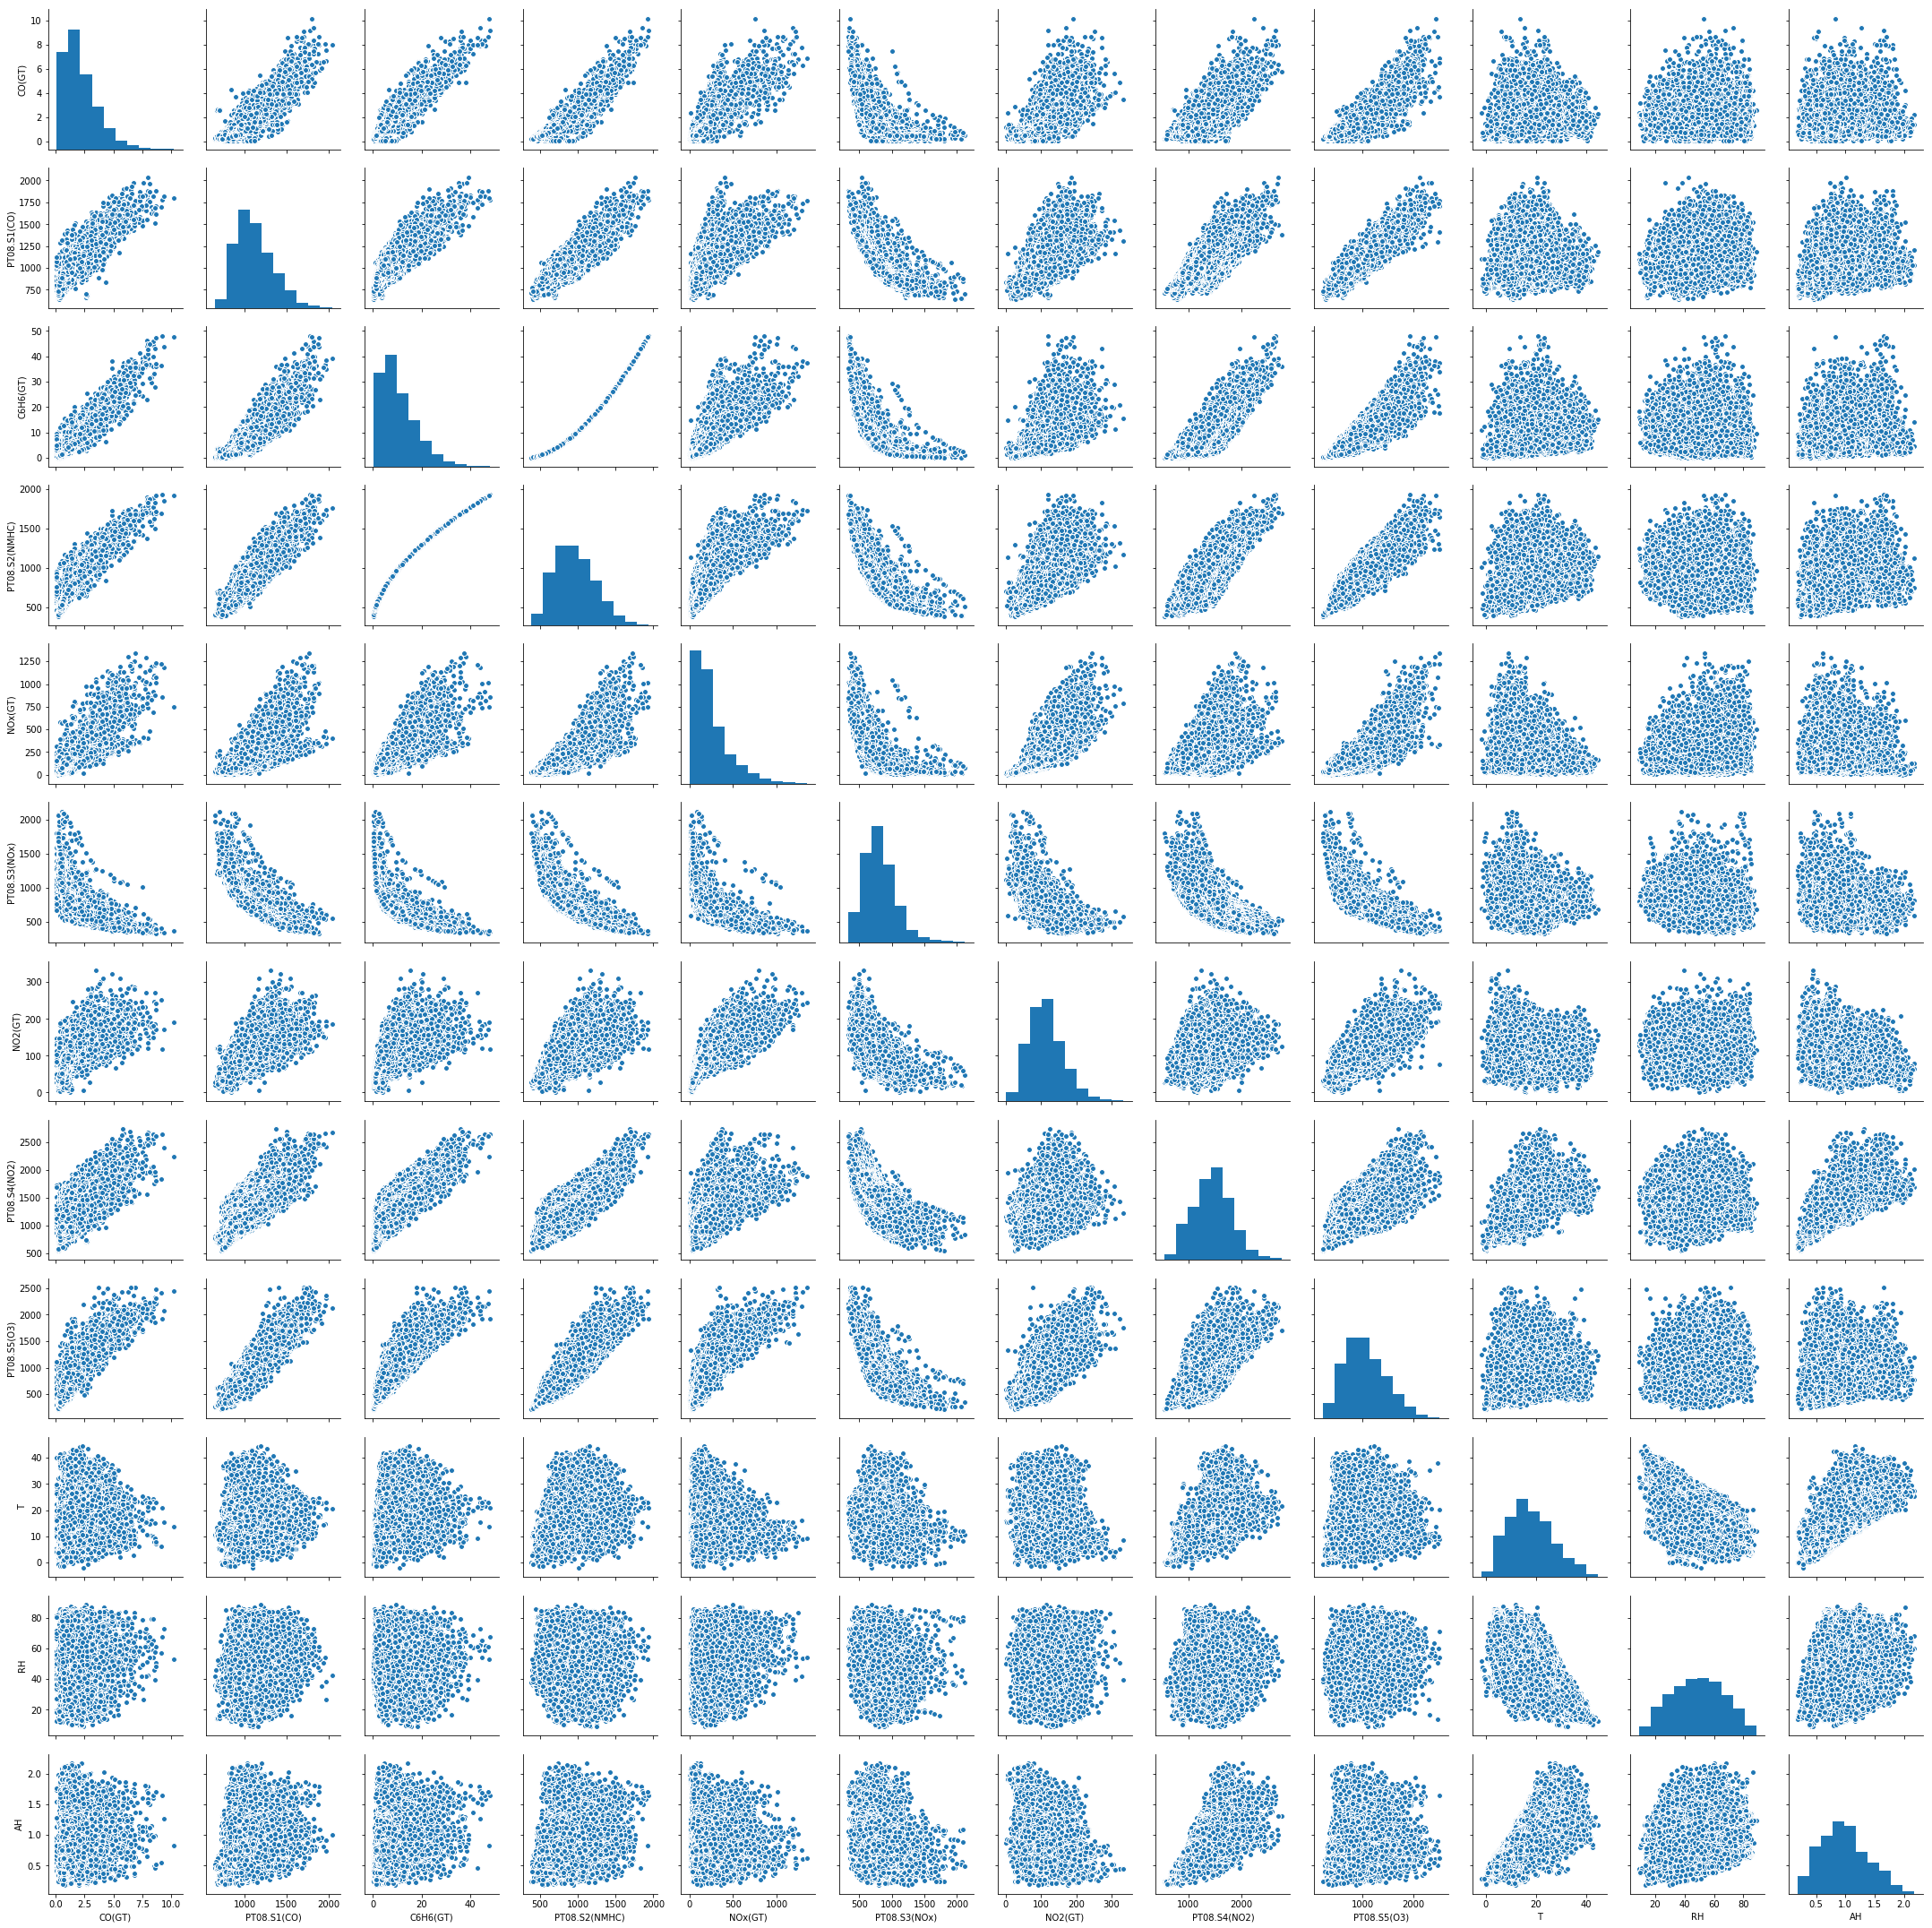

In [217]:
sns.pairplot(df1)

In [218]:
df1.corr()['C6H6(GT)']

CO(GT)           0.933357
PT08.S1(CO)      0.879284
C6H6(GT)         1.000000
PT08.S2(NMHC)    0.983823
NOx(GT)          0.712644
PT08.S3(NOx)    -0.737792
NO2(GT)          0.601595
PT08.S4(NO2)     0.765211
PT08.S5(O3)      0.861204
T                0.196689
RH              -0.027541
AH               0.191146
Name: C6H6(GT), dtype: float64

Ну вроде как получше. Выделим таргет из датасета, разделим на трейн и тест (причем нельзя перемешивать, поскольку это временные ряды, чтобы не заглядывать в будущее и соответственно дальше нужно будет использовать TimeSeriesSplit), построим бейзлайн в виде обычной регрессии без регуляризации. Нужно выбрать какую-нибудь метрику, будем смотреть на MAE, потому что MSE будет давать нам заниженный результат при разнице значений меньше 1, а диапазон значений у таргета у нас довольно маленький. А еще сначала отмасштабируем признаки.

In [248]:
y = df1['C6H6(GT)']

In [255]:
X = df1.drop(columns=['C6H6(GT)', 'DateTime'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

1.7458470050899848

In [256]:
model.coef_

array([ 1.61439777, -0.57100602,  6.21963789,  0.71926026,  1.01596219,
       -0.69541604,  0.6914353 ,  0.50085965, -0.21005616, -0.36379254,
        0.20843287])

CO(GT) PT08.S1(CO) PT08.S2(NMHC) NOx(GT) PT08.S3(NOx) NO2(GT) PT08.S4(NO2) PT08.S5(O3) T RH AH

Выкинем последние три фичи, они судя по графикам и коэффициентам корреляции несут мало полезной информации. И в модели коэффициенты у них самые низкие

In [258]:
X = df1.drop(columns=['C6H6(GT)', 'DateTime', 'T', 'RH', 'AH'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

1.7426689284208166

In [259]:
model.coef_

array([ 1.55347336, -0.67312122,  6.4744361 ,  0.60021106,  1.01745798,
       -0.62750153,  0.68572176,  0.43703687])

CO(GT) PT08.S1(CO) PT08.S2(NMHC) NOx(GT) PT08.S3(NOx) NO2(GT) PT08.S4(NO2) PT08.S5(O3)

Не исправило ситуацию. Выкинем NO2(GT) – у него вообще отрицательный коэффициент, хотя такого по графику быть не должно

In [267]:
X = df1.drop(columns=['C6H6(GT)', 'DateTime', 'T', 'RH', 'AH', 'NO2(GT)'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

1.3878701938788824

In [261]:
model.coef_

array([ 1.42981573, -0.62496707,  5.82300072,  0.63159097,  0.97213983,
        1.02502668,  0.32769692])

CO(GT) PT08.S1(CO) PT08.S2(NMHC) NOx(GT) PT08.S3(NOx) PT08.S4(NO2) PT08.S5(O3)

Выкинем NOx(GT)

In [262]:
X = df1.drop(columns=['C6H6(GT)', 'DateTime', 'T', 'RH', 'AH', 'NO2(GT)', 'NOx(GT)'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

1.2872675116428898

In [264]:
model.coef_

array([ 1.88022215, -0.68433447,  5.94638425,  0.86871404,  0.63331154,
        0.53970539])

CO(GT) PT08.S1(CO) PT08.S2(NMHC) PT08.S3(NOx) PT08.S4(NO2) PT08.S5(O3)

Выкинем PT08.S1(CO) – у него отрицательный коэффициент, хотя по графику такого быть не должно

In [271]:
X = df1.drop(columns=['C6H6(GT)', 'DateTime', 'T', 'RH', 'AH', 'NO2(GT)', 'NOx(GT)', 'PT08.S1(CO)'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

1.0931816662415312

In [272]:
model.coef_

array([1.58525568, 6.0173753 , 0.84821618, 0.45523592, 0.2285729 ])

CO(GT) PT08.S2(NMHC) PT08.S3(NOx) PT08.S4(NO2) PT08.S5(O3)

Посмотрим, чтоб будет, если выкинуть PT08.S5(O3)

In [275]:
X = df1.drop(columns=['C6H6(GT)', 'DateTime', 'T', 'RH', 'AH', 'NO2(GT)', 'NOx(GT)', 'PT08.S1(CO)', 'PT08.S5(O3)'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

1.090883845210674

Ошибка стала меньше, но несущественно, не будем выкидывать

Посмотрим, что будет, если бы вначале не выкинули три последние фичи

In [278]:
X = df1.drop(columns=['C6H6(GT)', 'DateTime', 'NO2(GT)', 'NOx(GT)', 'PT08.S1(CO)', 'PT08.S5(O3)'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

1.2182963558186457

Нет, выкинули мы кажется не зря. Хотя это жадный отбор и самая простая модель, поэтому точно сказать никак нельзя

Судя по коэффициентам [1.58525568, 6.0173753 , 0.84821618, 0.45523592, 0.2285729 ] CO(GT) PT08.S2(NMHC) PT08.S3(NOx) PT08.S4(NO2) PT08.S5(O3) можно сказать, что самыми важными являются фичиCO(GT) PT08.S2(NMHC)

Посмотрим что будет если оставить только их

In [280]:
X = df1[['CO(GT)', 'PT08.S2(NMHC)']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

1.0813034285274818

Ошибка уменьшилась на одну сотую. Не будет убирать все остальные фичи, оставим 6 штук их и попытаемся что-нибудь сделать с ними

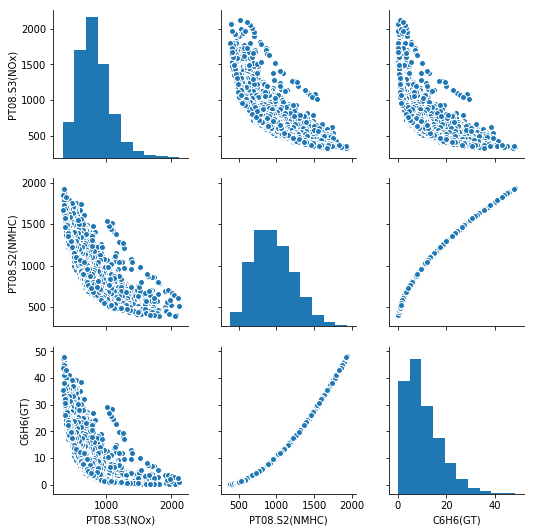

In [318]:
df2 = df1[['PT08.S3(NOx)', 'PT08.S2(NMHC)', 'C6H6(GT)']]
sns.pairplot(df2)

/home/majestic905/.venvs/ml/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/majestic905/.venvs/ml/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


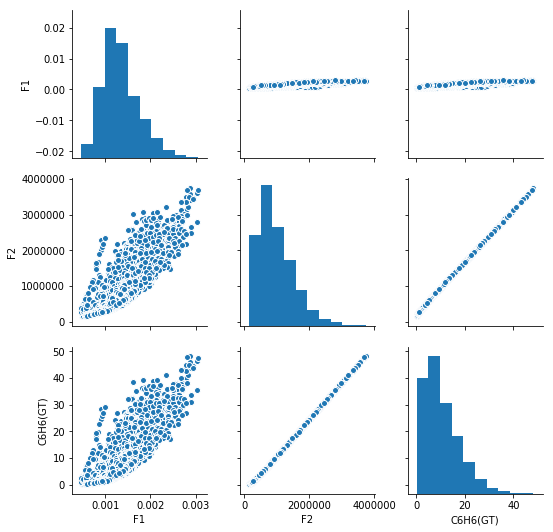

In [319]:
df2['F1'] = 1/df2['PT08.S3(NOx)']
df2['F2'] = df2['PT08.S2(NMHC)']**2
sns.pairplot(df2[['F1', 'F2', 'C6H6(GT)']])

Попробуем впихнуть то что получилось

In [356]:
X = df1.drop(columns=['C6H6(GT)', 'DateTime', 'T', 'RH', 'AH', 'NO2(GT)', 'NOx(GT)', 'PT08.S1(CO)'])
X['1/PT08.S3(NOx)'] = 1/X['PT08.S3(NOx)']
X['PT08.S2(NMHC)**2'] = X['PT08.S2(NMHC)']**2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.05181218007620637

In [357]:
model.coef_

array([-6.30592972e-03, -5.48542937e-01,  7.57950482e-02,  1.31896907e-03,
        1.37205656e-02,  4.80592432e-02,  8.03221946e+00])

CO(GT) PT08.S2(NMHC) PT08.S3(NOx) PT08.S4(NO2) PT08.S5(O3) 1/PT08.S3(NOx) PT08.S2(NMHC)**2

Выглядит неплохо. НО. Мы удалили все наблюдения с пропущенными значениями из датасета, и если в этом фиче значения не будет, то... то нифига. Т.е. получилось конечно очень хорошо, но это далеко не решение задачи

Поэтому сделаем вот что — возьмем исходный датасет, удалим наблюдения с пропусками в таргете, разделим выборку на трейн и тест, тест оставляем какой есть, из трейна удалим наблюдения с пропусками как и раньше, затем удалим выбросы, обучим на этом получившуюся модель с 7 фичами. На тесте будем заполнять пропуски средними значениями по столбцу из трейна. Ошибка станет больше, но будем наедеяться, что не космически

In [443]:
df3 = df.drop(df[df['C6H6(GT)'] == -200].index)
y3 = df3['C6H6(GT)']
X3 = df3[['CO(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]

In [444]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, shuffle=False, random_state=42)

In [438]:
X_train3 = pd.DataFrame(np.hstack((X_train3, y_train3.reshape((-1, 1)))), columns=['CO(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'C6H6(GT)'])

/home/majestic905/.venvs/ml/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [439]:
X_train3 = X_train3.replace({-200: np.nan}).dropna(how='any')

In [440]:
X_train3 = X_train3.drop(X_train3[X_train3['C6H6(GT)'] > 60].index)
X_train3 = X_train3.drop(X_train3[(X_train3['CO(GT)'] < 4) & (X_train3['C6H6(GT)'] > 30)].index)
X_train3 = X_train3.drop(X_train3[X_train3['PT08.S3(NOx)'] > 2200].index)
X_train3 = X_train3.drop(X_train3[(X_train3['PT08.S4(NO2)'] < 1700) & (X_train3['C6H6(GT)'] > 32)].index)
X_train3 = X_train3.drop(X_train3[X_train3['CO(GT)'] > 11].index)
X_train3 = X_train3.drop(X_train3[X_train3['C6H6(GT)'] > 50].index)

In [441]:
y_train3 = X_train3['C6H6(GT)']
X_train3 = X_train3.drop(columns=['C6H6(GT)'])

X_train3['1/PT08.S3(NOx)'] = 1/X_train3['PT08.S3(NOx)']
X_train3['PT08.S2(NMHC)**2'] = X_train3['PT08.S2(NMHC)']**2

X_test3.replace({
    'CO(GT)': {-200: X_train3['CO(GT)'].mean()},
    'PT08.S2(NMHC)': {-200: X_train3['PT08.S2(NMHC)'].mean()},
    'PT08.S3(NOx)': {-200: X_train3['PT08.S3(NOx)'].mean()},
    'PT08.S4(NO2)': {-200: X_train3['PT08.S4(NO2)'].mean()},
    'PT08.S5(O3)': {-200: X_train3['PT08.S5(O3)'].mean()}
})
X_test3['1/PT08.S3(NOx)'] = 1/X_test3['PT08.S3(NOx)']
X_test3['PT08.S2(NMHC)**2'] = X_test3['PT08.S2(NMHC)']**2

sc = StandardScaler()
X_train3 = sc.fit_transform(X_train3)
X_test3 = sc.transform(X_test3)

model = LinearRegression().fit(X_train3, y_train3)
y_pred = model.predict(X_test3)
mean_absolute_error(y_test3, y_pred)

/home/majestic905/.venvs/ml/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/majestic905/.venvs/ml/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


0.11537988834492129

In [460]:
model.coef_

array([-7.04801032e-03, -5.53836045e-01,  8.08726185e-02,  2.02085471e-03,
        1.20297662e-02,  5.04404739e-02,  8.11836659e+00])

Да, получилось неплохо

In [490]:
model = Ridge()
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error')
gs.fit(X_train3, y_train3)

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [497]:
gs.cv_results_

/home/majestic905/.venvs/ml/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/majestic905/.venvs/ml/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/majestic905/.venvs/ml/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/majestic905/

{'mean_fit_time': array([0.00398095, 0.0034198 , 0.00336965, 0.00314315, 0.00345071,
        0.00346216, 0.00587273, 0.00376781, 0.00327373]),
 'mean_score_time': array([0.00086435, 0.00081905, 0.00308379, 0.00435217, 0.00281405,
        0.00212177, 0.00190218, 0.00078901, 0.00071867]),
 'mean_test_score': array([-1.20742981, -1.20742981, -1.20742981, -1.20742981, -1.20742981,
        -1.2074298 , -1.20742979, -1.20742975, -1.20742969]),
 'mean_train_score': array([-0.80940132, -0.80940132, -0.80940132, -0.80940132, -0.80940132,
        -0.80940132, -0.80940132, -0.8094013 , -0.80940127]),
 'param_alpha': masked_array(data=[0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.0001},
  {'alpha': 0.001},
  {'alpha': 0.01},
  {'alpha': 0.05},
  {'alpha': 0.1},
  {'alpha': 0.5},
  {'alpha': 1},
  {'alpha': 5},
  {'alp

In [495]:
model = gs.best_estimator_
model.fit(X_train3, y_train3)
y_pred = model.predict(X_test3)
mean_absolute_error(y_test3, y_pred)

1.2732335240788601